In [1]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')

import scFates as scf

%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
#plt.style.use('seaborn-colorblind')

In [3]:
remove_genes = ['IGHM', 'CCL16', 'CCR3','CD3G','TH','NEUROD6','CD4','PLP1']

In [4]:
from scipy import sparse
def get_X(adata, cells, genes, layer, togenelist=False):
    if layer is None:
        if sparse.issparse(adata.X):
            X = adata[cells, genes].X.A
        else:
            X = adata[cells, genes].X
    else:
        if sparse.issparse(adata.layers[layer]):
            X = adata[cells, genes].layers[layer].A
        else:
            X = adata[cells, genes].layers[layer]

    if togenelist:
        return X.T.tolist()
    else:
        return X


In [5]:
adata = sc.read_h5ad('GWlike_scfates.h5ad')


In [6]:
adata

AnnData object with n_obs × n_vars = 984964 × 387
    obs: 'Area', 'CellID', 'Centroid', 'Polygons', 'Sample', 'X', 'Y', 'batch', 'ID', 'CellularNgh', 'm-states', 'm-states80', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'Accession', 'Gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'p_val', 'A', 'fdr', 'st', 'signi', 'clusters'
    uns: 'graph', 'hvg', 'log1p', 'm-states_colors', 'milestones_colors', 'pca', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'fitted'

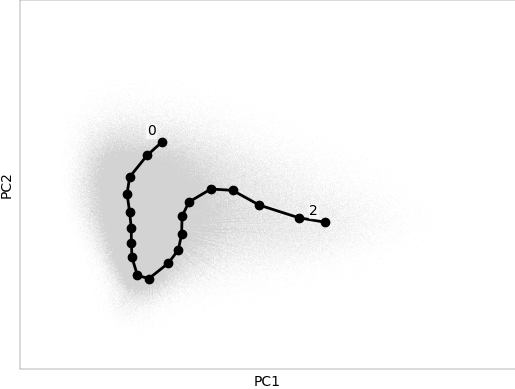

In [7]:
scf.pl.graph(adata,basis="pca")

In [9]:
import pandas as pd
import numpy as np

feature='VEGFA'
Xfeature = np.array(get_X(adata, adata.obs_names, feature, None)).ravel()
df = pd.DataFrame(
    {
        "t": adata.obs.t,
        "fitted": np.array(
            get_X(adata, adata.obs_names, 'VEGFA', "fitted")
        ).ravel(),
        "expression": Xfeature,
        "seg": adata.obs.seg,
    }
).sort_values("t")

In [10]:
def plot_curves(
    adata,
    genes,
    figsize=(5,5),
    gene_color=None,
    return_dic=False,
    scatter=True,
    plot=True,
    save_name=None,
    ):
    
    dfs = {}
    fig, ax_trend = plt.subplots(figsize=figsize)
    
    for feature in genes:
        #feature = 'VEGFA'
        layer=None
        Xfeature = np.array(get_X(adata, adata.obs_names, feature, layer)).ravel()

        df = pd.DataFrame(
            {
                "t": adata.obs.t,
                "fitted": np.array(
                    get_X(adata, adata.obs_names, feature, "fitted")
                ).ravel(),
                "expression": Xfeature,
                "seg": adata.obs.seg,
            }
        ).sort_values("t")
        if df.fitted.min() < 0:
            df['fitted'] -= df.fitted.min()
        if df.expression.min() < 0:
            df['expression'] -= df.expression.min()
        
        dfs[feature] = df
        

        color_exp = 'k'
        alpha_expr= 0.01
        size_expr= .1
        fitted_linewidth = 3
        s = '1'
        
        if plot:
            if scatter:
                ax_trend.scatter(
                    df.loc[df.seg == s, "t"],
                    df.loc[df.seg == s, "expression"],
                    c=gene_color[feature],
                    alpha=alpha_expr,
                    s=size_expr,
                    rasterized=True,
                )
            ax_trend.plot(
                df.loc[df.seg == s, "t"],
                df.loc[df.seg == s, "fitted"],
                c=gene_color[feature],
                linewidth=fitted_linewidth,
            )
            
    #ax_trend.spines['top'].set_visible(False)
    #ax_trend.spines['right'].set_visible(False)
    #ax_trend.spines['left'].set_visible(False)
    #ax_trend.spines['bottom'].set_visible(False)
    plt.axis('off')
    if plot:
        if save_name is not None:
            print('saving')
            plt.savefig(save_name,dpi=300, format='pdf',bbox_inches='tight')
        plt.show()

    if return_dic:
        return dfs

        

saving


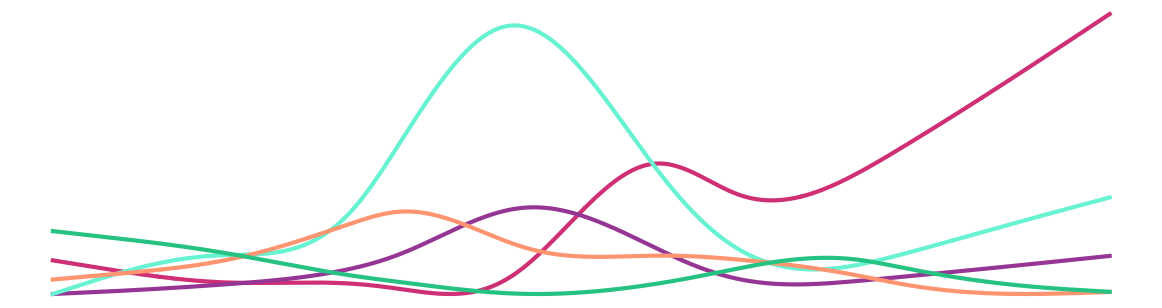

In [16]:
dfs = plot_curves(
    adata,
    ['VEGFA','SERPINE1', 'VIM', 'LGALS1', 'AQP4'],
    plot=True,
    return_dic=True,
    scatter=False,
    gene_color={'VEGFA':'#cf2f74',
                'SERPINE1':'#963694', 
                'VIM':'#67f2d1', 
                'LGALS1':'#ff9470', 
                'AQP4':'#26c281',
                #'CD44': '#ffff9f',
                #'SPP1':'#9b59b6',
               },
    save_name='figures/pseudotime_genes.pdf',
    figsize=(15,4),
    
)

In [17]:
'''dfs = plot_curves(
    adata,
    ['VEGFA','SERPINE1', 'VIM', 'LGALS1', 'AQP4','SPP1'],
    plot=True,
    return_dic=True,
    scatter=False,
    gene_color={'VEGFA':'#cf2f74',
                'SERPINE1':'#963694', 
                'VIM':'#67f2d1', 
                'LGALS1':'#ff9470', 
                #'AQP4':'#d2ee82',
                #'CD44': '#ffff9f',
                'SPP1':'#9b59b6',
               },
    save_name='../Fig2/pseudotime_genes.pdf',
    figsize=(15,4),
    
)'''

"dfs = plot_curves(\n    adata,\n    ['VEGFA','SERPINE1', 'VIM', 'LGALS1', 'AQP4','SPP1'],\n    plot=True,\n    return_dic=True,\n    scatter=False,\n    gene_color={'VEGFA':'#cf2f74',\n                'SERPINE1':'#963694', \n                'VIM':'#67f2d1', \n                'LGALS1':'#ff9470', \n                #'AQP4':'#d2ee82',\n                #'CD44': '#ffff9f',\n                'SPP1':'#9b59b6',\n               },\n    save_name='../Fig2/pseudotime_genes.pdf',\n    figsize=(15,4),\n    \n)"

In [18]:
gene_color={
    'SOX2':'#cf2f74',
    'SOX9':'#963694', 
    'FOXG1':'#67f2d1',#'#963694', 
    'NOTCH1':'#ff9470',
    'OLIG1': '#26c281',


}


saving


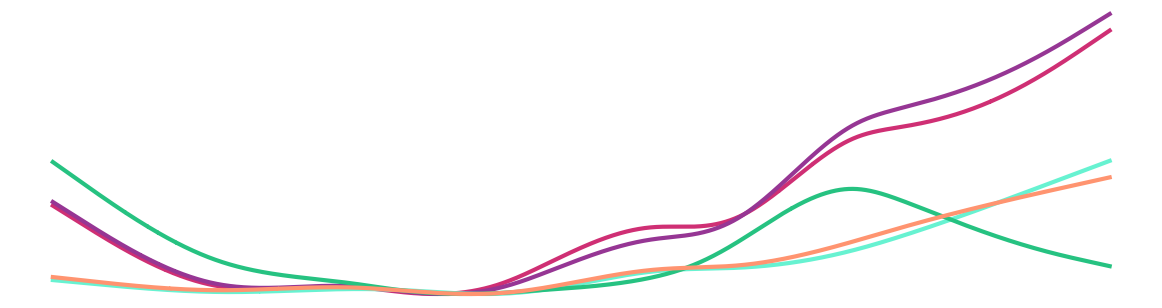

In [19]:
dfs = plot_curves(
    adata,
    ['SOX2', 'SOX9', 'FOXG1', 'OLIG1', 'NOTCH1'],

    plot=True,
    return_dic=True,
    scatter=False,
    gene_color=gene_color,
    figsize=(15,4),
    save_name='figures/pseudotime_genes_glia.pdf'
)

In [ ]:
dfs = plot_curves(
    adata,
    ['SOX2', 'SOX9', 'FOXG1', 'OLIG1', 'NOTCH1'],
    plot=True,
    return_dic=True,
    scatter=False,
    gene_color=gene_color,
    figsize=(12,4),
    save_name='figures/pseudotime_genes_glia.pdf'
)

In [ ]:
import seaborn as sns

In [ ]:
'''d = dfs['VEGFA']
d = d[d.expression != 0]
print(d.shape)
#f = np.isin(np.arange(d.shape[0]), np.random.choice(np.arange(d.shape[0]),2000,replace=False))
d = d.iloc[np.random.choice(np.arange(d.shape[0]),20000,replace=False),:]
print(d.shape)
sns.lmplot(
    d, 
    x="t", 
    y="expression", 
    x_estimator=np.mean, 
    order=4,
    #ci=None,
    #x_ci='sd',
    scatter_kws={'s':.01}
)'''

In [ ]:
scf.pl.single_trend(adata_export,"VEGFA",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
scf.pl.single_trend(adata,"VEGFA",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"VIM",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"SERPINE1",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"LGALS1",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"AQP4",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
scf.pl.single_trend(adata,"FOXG1",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
scf.pl.single_trend(adata,"SOX9",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"OLIG1",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"OLIG2",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
scf.pl.single_trend(adata,"SOX2",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
scf.pl.single_trend(adata,"NOTCH1",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
scf.pl.single_trend(adata,"NEUROD2",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
adata.obs.seg.cat.categories

In [ ]:
scf.pl.single_trend(adata,"NEUROG6",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:
#scf.pl.single_trend(adata,"DLX2",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"DLX5",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)
scf.pl.single_trend(adata,"DLX6",basis="pca",color_exp="k", alpha_expr=0.1, size_expr=.01,fitted_linewidth=5,)

In [ ]:

scf.tl.cluster(adata, n_neighbors=50, metric="cosine")

In [ ]:
adata.var['clusters'].cat.categories

In [ ]:
adata.var['clusters'] = adata.var.clusters.astype('category')
adata.obs['seg'] = adata.obs.seg.astype('category')

In [ ]:
for c in adata.var["clusters"].unique():
    scf.pl.trends(
        adata,
        features=adata.var_names[adata.var.clusters==c],
        basis='pca',
        feature_cmap='PuRd',
        plot_emb=True,
        annot=None,
        pseudo_cmap = 'magma',
        #save='figures/cluster{}.pdf'.format(c)
    )


In [ ]:
adata.var_names

In [ ]:
for c in adata.var["clusters"].unique():  
    mean = adata.raw[:,adata.var_names[adata.var.clusters== c]].X.mean(axis=1)#adata[:,adata.var_names[adata.var.clusters== '2']]
    adata.obs['mean_'] = mean
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    # scatter with colormap mapping to z value
    ax.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=0.1,c=adata.obs['mean_'], cmap = 'PuRd')
    plt.show()

In [ ]:
for c in adata.var["clusters"].unique():
    scf.pl.trends(
        adata,
        features=adata.var_names[adata.var.clusters==c],
        basis="pca",
        feature_cmap='PuRd',
        plot_emb=False,
        pseudo_cmap = 'magma',
        save='figures/cluster{}.pdf'.format(c)
    )